In [2]:
import os
import sys
import torch
import importlib
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from PIL import Image
from ipywidgets import widgets, interact
from IPython.display import display, clear_output
from utils.data_utils import create_video_from_frames  # Import the video creation function

In [3]:
# Add the root directory to the path for imports
if os.path.dirname(os.getcwd()) not in sys.path:
    sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
# ======== CONFIGURATION ========
# Set your paths and configuration here
CONFIG = {
    # Dataset path
    "dataset_path": "/home/stud/lavingal/storage/slurm/lavingal/LVSM/datasets/re10k/test/full_list.txt",
    
    # Specific checkpoint to load (set to empty to use latest from checkpoint_dir)
    "specific_checkpoint": "/home/stud/lavingal/storage/slurm/lavingal/LVSM/experiments/checkpoints/LVSM_scene_decoder_only/ckpt_0000000000246000.pt",
    
    # Checkpoint directory (used if specific_checkpoint is empty)
    "checkpoint_dir": "../experiments/checkpoints/LVSM_scene_decoder_only",
    
    # Device to use
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    
    # Model configuration file (will be overridden with loaded values)
    "config_file": "/home/stud/lavingal/storage/slurm/lavingal/LVSM/configs/LVSM_scene_decoder_only.yaml",

    # Output directory for saved videos
    "output_dir": "./rendered_videos",
}

In [5]:
# Create output directory if it doesn't exist
os.makedirs(CONFIG["output_dir"], exist_ok=True)

[Helper functions section remains unchanged]
... [include all the helper functions from the original code] ...

In [6]:
def load_config(config_path=None):
    """Load configuration from YAML file"""
    if config_path and os.path.exists(config_path):
        import yaml
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
    else:
        # Use default config
        config = {
            "model": {
                "class_name": "model.LVSM_scene_decoder_only.Images2LatentScene",
                "image_tokenizer": {
                    "image_size": 256,
                    "patch_size": 8,
                    "in_channels": 9  # 3 RGB + 3 direction + 3 Reference
                },
                "target_pose_tokenizer": {
                    "image_size": 256,
                    "patch_size": 8,
                    "in_channels": 6  # 3 direction + 3 Reference
                },
                "transformer": {
                    "d": 768,
                    "d_head": 64,
                    "n_layer": 6,
                    "special_init": True,
                    "depth_init": True,
                    "use_qk_norm": True
                }
            },
            "training": {
                "amp_dtype": "bf16",
                "batch_size_per_gpu": 1,
                "center_crop": True,
                "scene_scale_factor": 1.35,
                "checkpoint_dir": CONFIG["checkpoint_dir"],
                "dataset_name": "data.dataset_scene.Dataset",
                "dataset_path": CONFIG["dataset_path"],
                "num_input_views": 2,
                "num_target_views": 6,
                "num_threads": 8,
                "num_views": 8,
                "num_workers": 1,
                "square_crop": True,
                "target_has_input": True,
                "use_amp": False,
                "use_tf32": False,
                "view_selector": {
                    "max_frame_dist": 192,
                    "min_frame_dist": 25
                }
            },
            "inference": {
                "render_video": True,
                "render_video_config": {
                    "traj_type": "interpolate",
                    "num_frames": 10,
                    "loop_video": False,
                    "order_poses": False
                }
            }
        }
    
    # Convert to EasyDict for easier access
    config = edict(config)
    
    # Override with our specific settings
    config.training.dataset_path = CONFIG["dataset_path"]
    config.training.checkpoint_dir = CONFIG["checkpoint_dir"]
    config.training.batch_size_per_gpu = 1
    config.training.num_workers = 1
    config.training.use_amp = False
    
    return config

In [7]:
def load_model(config):
    """Load the LVSM model and checkpoint"""
    # Set up mock distributed environment to avoid DDP-related errors
    import torch.distributed as dist
    if not dist.is_available() or not dist.is_initialized():
        import random
        # Use random port to avoid conflicts
        random_port = random.randint(29500, 65000)
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = str(random_port)
        os.environ['RANK'] = '0'
        os.environ['WORLD_SIZE'] = '1'
        if dist.is_available():
            try:
                dist.init_process_group(backend='gloo', rank=0, world_size=1)
            except RuntimeError:
                print("Warning: Could not initialize distributed environment. Continuing without it.")
    
    # Initialize LPIPS separately to avoid distributed initialization errors
    import lpips
    # Suppress future warnings
    import warnings
    warnings.filterwarnings('ignore', category=FutureWarning)
    
    # Create a custom class that inherits from the original but overrides problematic methods
    module, class_name = config.model.class_name.rsplit(".", 1)
    LVSM_Base = importlib.import_module(module).__dict__[class_name]
    
    class LVSMSingleDevice(LVSM_Base):
        def __init__(self, config):
            # Save original config settings
            orig_l2_weight = config.training.l2_loss_weight
            orig_lpips_weight = config.training.lpips_loss_weight
            orig_perceptual_weight = config.training.perceptual_loss_weight
            
            # Temporarily disable loss components to avoid DDP initialization
            config.training.l2_loss_weight = 1.0
            config.training.lpips_loss_weight = 0.0
            config.training.perceptual_loss_weight = 0.0
            
            # Initialize the base class
            super().__init__(config)
            
            # Restore original config settings
            config.training.l2_loss_weight = orig_l2_weight
            config.training.lpips_loss_weight = orig_lpips_weight
            config.training.perceptual_loss_weight = orig_perceptual_weight
    
    # Create model instance
    model = LVSMSingleDevice(config).to(CONFIG["device"])
    
    # Load checkpoint
    ckpt_path = CONFIG["specific_checkpoint"] if CONFIG["specific_checkpoint"] else config.training.checkpoint_dir
    model.load_ckpt(ckpt_path)
    model.eval()
    
    return model

In [8]:
def load_dataset(config):
    """Load the dataset"""
    dataset_name = config.training.dataset_name
    module, class_name = dataset_name.rsplit(".", 1)
    Dataset = importlib.import_module(module).__dict__[class_name]
    dataset = Dataset(config)
    return dataset

In [9]:
def show_image_grid(images, titles=None, figsize=(15, 15), rows=None, cols=None):
    """Display a grid of images"""
    if isinstance(images, torch.Tensor):
        # Convert from bfloat16 to float32 if needed
        if images.dtype == torch.bfloat16:
            images = images.to(torch.float32)
        # Convert from tensor [B, C, H, W] to numpy [B, H, W, C]
        images = images.detach().cpu().numpy().transpose(0, 2, 3, 1)
    
    # Determine grid size
    n_images = len(images)
    if rows is None and cols is None:
        cols = int(np.ceil(np.sqrt(n_images)))
        rows = int(np.ceil(n_images / cols))
    elif rows is None:
        rows = int(np.ceil(n_images / cols))
    elif cols is None:
        cols = int(np.ceil(n_images / rows))
    
    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows * cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Plot images
    for i, ax in enumerate(axes):
        if i < n_images:
            if images[i].shape[-1] == 1:  # Grayscale
                ax.imshow(images[i].squeeze(), cmap='gray')
            else:
                # Ensure values are in proper range for display
                img = np.clip(images[i], 0, 1)
                ax.imshow(img)
            
            if titles is not None and i < len(titles):
                ax.set_title(titles[i])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [10]:
def process_c2w_matrix(c2w):
    """Process camera-to-world matrix for display"""
    # Extract rotation and translation
    rotation = c2w[:3, :3]
    translation = c2w[:3, 3]
    
    # Convert rotation to Euler angles (in degrees)
    from scipy.spatial.transform import Rotation
    euler = Rotation.from_matrix(rotation.cpu().numpy()).as_euler('xyz', degrees=True)
    
    return {
        'translation': translation.cpu().numpy(),
        'rotation_euler_deg': euler,
        'full_matrix': c2w.cpu().numpy()
    }

In [11]:
def get_ray_bundle(fxfycxcy, c2w, height, width, device="cpu"):
    """Generate rays for a camera view"""
    # Create pixel coordinates
    i, j = torch.meshgrid(
        torch.arange(width, device=device),
        torch.arange(height, device=device),
        indexing="ij"
    )
    i = i.t()
    j = j.t()
    
    # Convert to normalized device coordinates
    fx, fy, cx, cy = fxfycxcy
    dirs = torch.stack(
        [
            (i - cx) / fx,
            -(j - cy) / fy,
            -torch.ones_like(i),
        ],
        dim=-1,
    )
    
    # Transform ray directions to world space
    rays_d = dirs @ c2w[:3, :3].t()
    rays_d = rays_d / torch.linalg.norm(rays_d, dim=-1, keepdim=True)
    
    # Get ray origins from camera position
    rays_o = c2w[:3, 3].expand(rays_d.shape)
    
    return rays_o, rays_d

In [12]:
def create_custom_camera(base_camera, tx=0.0, ty=0.0, tz=0.0, rx=0.0, ry=0.0, rz=0.0):
    """Create a custom camera by modifying the base camera parameters"""
    # Start with the base camera
    c2w = base_camera.clone()
    
    # Create rotation matrices for the adjustments
    from scipy.spatial.transform import Rotation
    r = Rotation.from_euler('xyz', [rx, ry, rz], degrees=True)
    rot_matrix = torch.tensor(r.as_matrix(), dtype=c2w.dtype, device=c2w.device)
    
    # Apply rotation to the existing rotation matrix
    c2w[:3, :3] = torch.matmul(rot_matrix, c2w[:3, :3])
    
    # Apply translation adjustments
    c2w[0, 3] += tx
    c2w[1, 3] += ty
    c2w[2, 3] += tz
    
    return c2w

In [13]:
# ======== MAIN CODE ========
# Load configuration
config = load_config(CONFIG.get("config_file"))
# Modify config to avoid distributed training issues
config.training.use_amp = False
config.training.use_tf32 = False

In [14]:
# Load dataset
dataset = load_dataset(config)
print(f"Dataset loaded with {len(dataset)} scenes")

Dataset loaded with 7286 scenes


In [15]:

try:
    model = load_model(config)
    print(f"Model loaded from {CONFIG['specific_checkpoint'] if CONFIG['specific_checkpoint'] else config.training.checkpoint_dir}")
except Exception as e:
    print(f"Error loading model: {str(e)}")
    import traceback
    traceback.print_exc()

Model loaded from /home/stud/lavingal/storage/slurm/lavingal/LVSM/experiments/checkpoints/LVSM_scene_decoder_only/ckpt_0000000000246000.pt


In [ ]:
# Function to select a scene and display input and target views
def select_scene(scene_idx=0):
    """Select a scene and display input and target views"""
    if scene_idx < 0 or scene_idx >= len(dataset):
        print(f"Scene index out of range. Please choose between 0 and {len(dataset)-1}")
        return None
    
    try:
        # Get scene data
        scene_data = dataset[scene_idx]
        
        # Move to device
        scene_data = {k: v.to(CONFIG["device"]) if isinstance(v, torch.Tensor) else v 
                    for k, v in scene_data.items()}
        
        # Get batch dimension right
        for k, v in scene_data.items():
            if isinstance(v, torch.Tensor) and v.dim() > 0:
                scene_data[k] = v.unsqueeze(0)
        
        # Process data through model's process_data function
        with torch.no_grad():
            input_data, target_data = model.process_data(
                scene_data, 
                has_target_image=True, 
                target_has_input=config.training.target_has_input, 
                compute_rays=True
            )
    
    except Exception as e:
        print(f"Error processing scene {scene_idx}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None
    
    # Display input views
    print("\n=== Input Views ===")
    input_images = input_data.image.squeeze(0)  # [v, c, h, w]
    show_image_grid(input_images, titles=[f"Input View {i}" for i in range(input_images.shape[0])])
    
    # Display camera parameters for input views
    print("\n=== Input Camera Parameters ===")
    for i in range(input_data.c2w.shape[1]):
        c2w_info = process_c2w_matrix(input_data.c2w[0, i])
        print(f"Input View {i}:")
        print(f"  Translation: {c2w_info['translation']}")
        print(f"  Rotation (Euler XYZ, degrees): {c2w_info['rotation_euler_deg']}")
        print()
    
    # Display target views
    print("\n=== Target Views ===")
    target_images = target_data.image.squeeze(0)  # [v, c, h, w]
    show_image_grid(target_images, titles=[f"Target View {i}" for i in range(target_images.shape[0])])
    
    # Display camera parameters for target views
    print("\n=== Target Camera Parameters ===")
    for i in range(target_data.c2w.shape[1]):
        c2w_info = process_c2w_matrix(target_data.c2w[0, i])
        print(f"Target View {i}:")
        print(f"  Translation: {c2w_info['translation']}")
        print(f"  Rotation (Euler XYZ, degrees): {c2w_info['rotation_euler_deg']}")
        print()
    
    return {"input": input_data, "target": target_data, "scene_data": scene_data}

In [ ]:
def render_incremental(scene_idx, step_size=0.4, num_steps=10, 
                       axis='x', positive_direction=True):
    """
    Incrementally render views, always using the two most recent views as input
    and discarding the oldest view after each step.
    
    Returns the final rendered image at the furthest point.
    """
    # Get initial scene data
    scene_output = select_scene(scene_idx)
    if not scene_output:
        print("Failed to load scene data")
        return None
    
    # Get the input camera matrices and images
    input_cameras = scene_output["input"].c2w[0]  # [num_input_views, 4, 4]
    input_images = scene_output["input"].image[0]  # [num_input_views, C, H, W]
    device = input_cameras.device
    
    # Determine which axis we're moving along
    axis_idx = {'x': 0, 'y': 1, 'z': 2}[axis.lower()]
    direction = 1 if positive_direction else -1
    
    # Sort cameras by their position along the chosen axis
    positions = [cam[axis_idx, 3].item() for cam in input_cameras]
    print(f"Camera positions along {axis}-axis: {positions}")
    

    # FIRST CAMERA TO BE DISCARDED IS THE ONE FARTHER AWAY FROM THE TARGET
    # Select the two cameras based on our movement direction
    if positive_direction:
        # If moving positive, use the two cameras with the largest coordinate values
        sorted_indices = sorted(range(len(positions)), key=lambda i: positions[i], reverse=True)
    else:
        # If moving negative, use the two cameras with the smallest coordinate values
        sorted_indices = sorted(range(len(positions)), key=lambda i: positions[i])
    
    # Use the first two sorted cameras
    current_camera_indices = sorted_indices[:2]
    print(f"Using cameras at indices {current_camera_indices}")
    
    # Initialize our two cameras and images
    current_cameras = [input_cameras[i].clone() for i in current_camera_indices]
    current_images = [input_images[i].clone() for i in current_camera_indices]
    
    # Get the starting position (from the camera furthest along our trajectory)
    current_pos = current_cameras[1][:3, 3].clone().cpu().numpy()
    print(f"Starting position: {current_pos}")
    
    # Track our latest rendered image
    latest_rendered_image = current_images[1].clone()
    
    # For each step, generate a new view
    for step in range(num_steps):
        # Calculate the next target position
        next_pos = current_pos.copy()
        next_pos[axis_idx] += direction * step_size
        
        print(f"Step {step+1}/{num_steps}: Generating view at position {next_pos}")
        
        # Create the target camera by modifying the current camera
        target_c2w = current_cameras[1].clone()
        # Apply the translation
        for i in range(3):
            target_c2w[i, 3] = torch.tensor(next_pos[i], device=device)
        
        # Create a deep copy of the scene data to modify
        raw_scene_data = {k: v.clone() if isinstance(v, torch.Tensor) else v 
                          for k, v in scene_output["scene_data"].items()}
        
        # Replace the input views with our current two views
        raw_scene_data["image"][0, 0] = current_images[0]
        raw_scene_data["image"][0, 1] = current_images[1]
        raw_scene_data["c2w"][0, 0] = current_cameras[0]
        raw_scene_data["c2w"][0, 1] = current_cameras[1]
        
        # Set the target view
        num_input_views = config.training.num_input_views
        target_view_idx = num_input_views  # First target view position
        raw_scene_data["c2w"][0, target_view_idx] = target_c2w
        
        # Render the new view
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=True, dtype=torch.bfloat16):
                # Process data through model
                result = model(raw_scene_data, has_target_image=False)
                # Generate just the single target view (not a full video)
                result = model.render_video(result, num_frames=1, loop_video=False)
        
        # Extract the rendered frame
        new_frame = result.video_rendering.squeeze(0).cpu()  # [1, 3, H, W]
        if new_frame.dtype == torch.bfloat16:
            new_frame = new_frame.to(torch.float32)
        
        # Update our latest rendered image
        latest_rendered_image = new_frame[0].to(device)

        printable_latest_rendered_image = latest_rendered_image.permute(1, 2, 0).cpu().numpy()

            # Display the image
        plt.figure(figsize=(8, 8))
        plt.imshow(printable_latest_rendered_image)
        plt.title(f"rendered view at Step={step+1}")
        plt.axis('off')
        plt.show()
            
        # Update our sliding window for the next iteration - discard the oldest view
        current_cameras = [current_cameras[1].clone(), target_c2w.clone()]
        current_images = [current_images[1].clone(), latest_rendered_image.clone()]
        
        # Update the current position for the next step
        current_pos = next_pos
    
    # Convert final image to numpy for easier handling
    final_image = latest_rendered_image.permute(1, 2, 0).cpu().numpy()
    
    print(f"Final position reached: {current_pos}")
    
    
    
    return final_image, current_cameras[1]  # Return the final image and its camera


=== Input Views ===


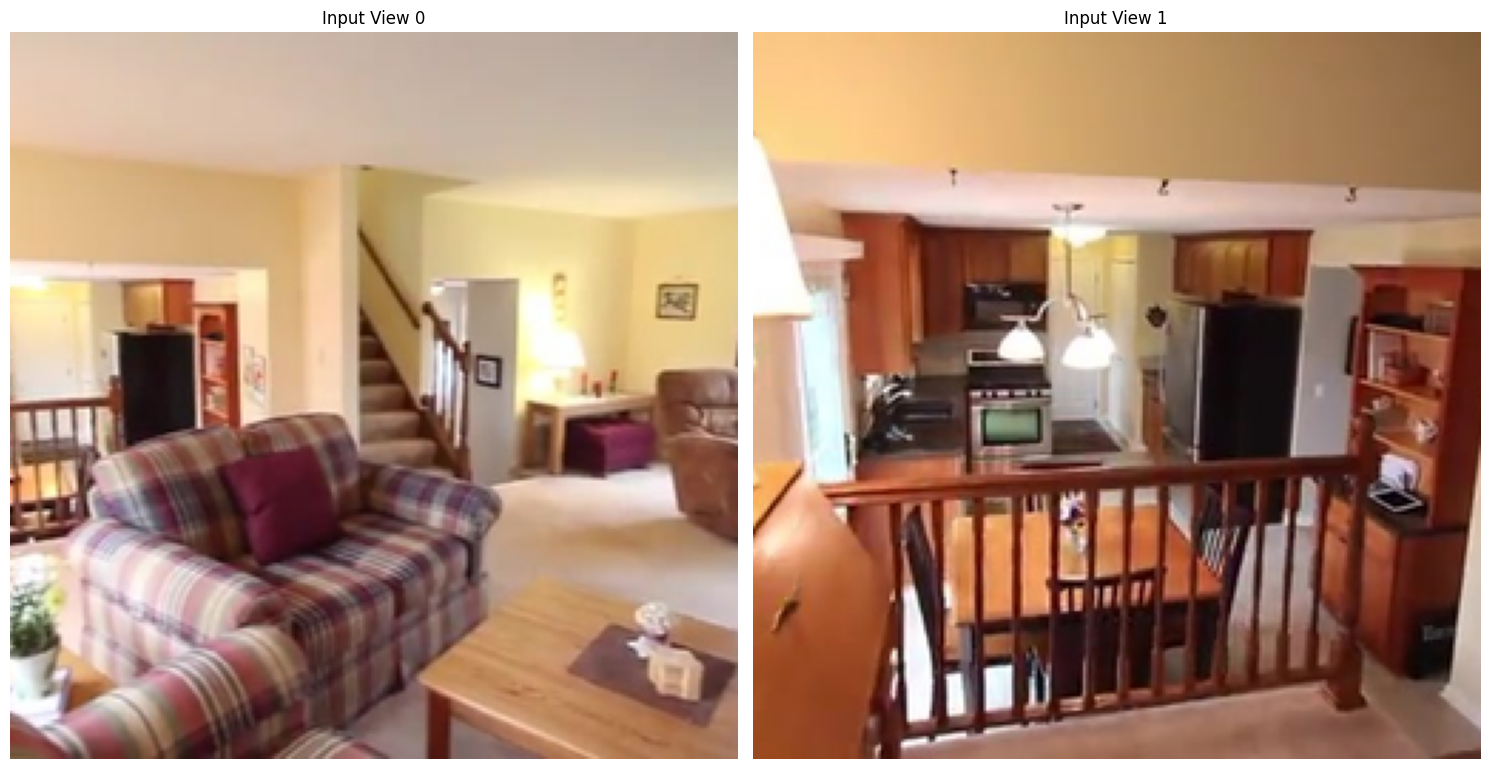


=== Input Camera Parameters ===
Input View 0:
  Translation: [ 0.23669681  0.06116434 -0.3063425 ]
  Rotation (Euler XYZ, degrees): [ 1.51755732 11.65945883  2.35614435]

Input View 1:
  Translation: [-0.42746443 -0.12899143  0.7407407 ]
  Rotation (Euler XYZ, degrees): [-2.30181685 -5.97023944 -1.11963743]


=== Target Views ===


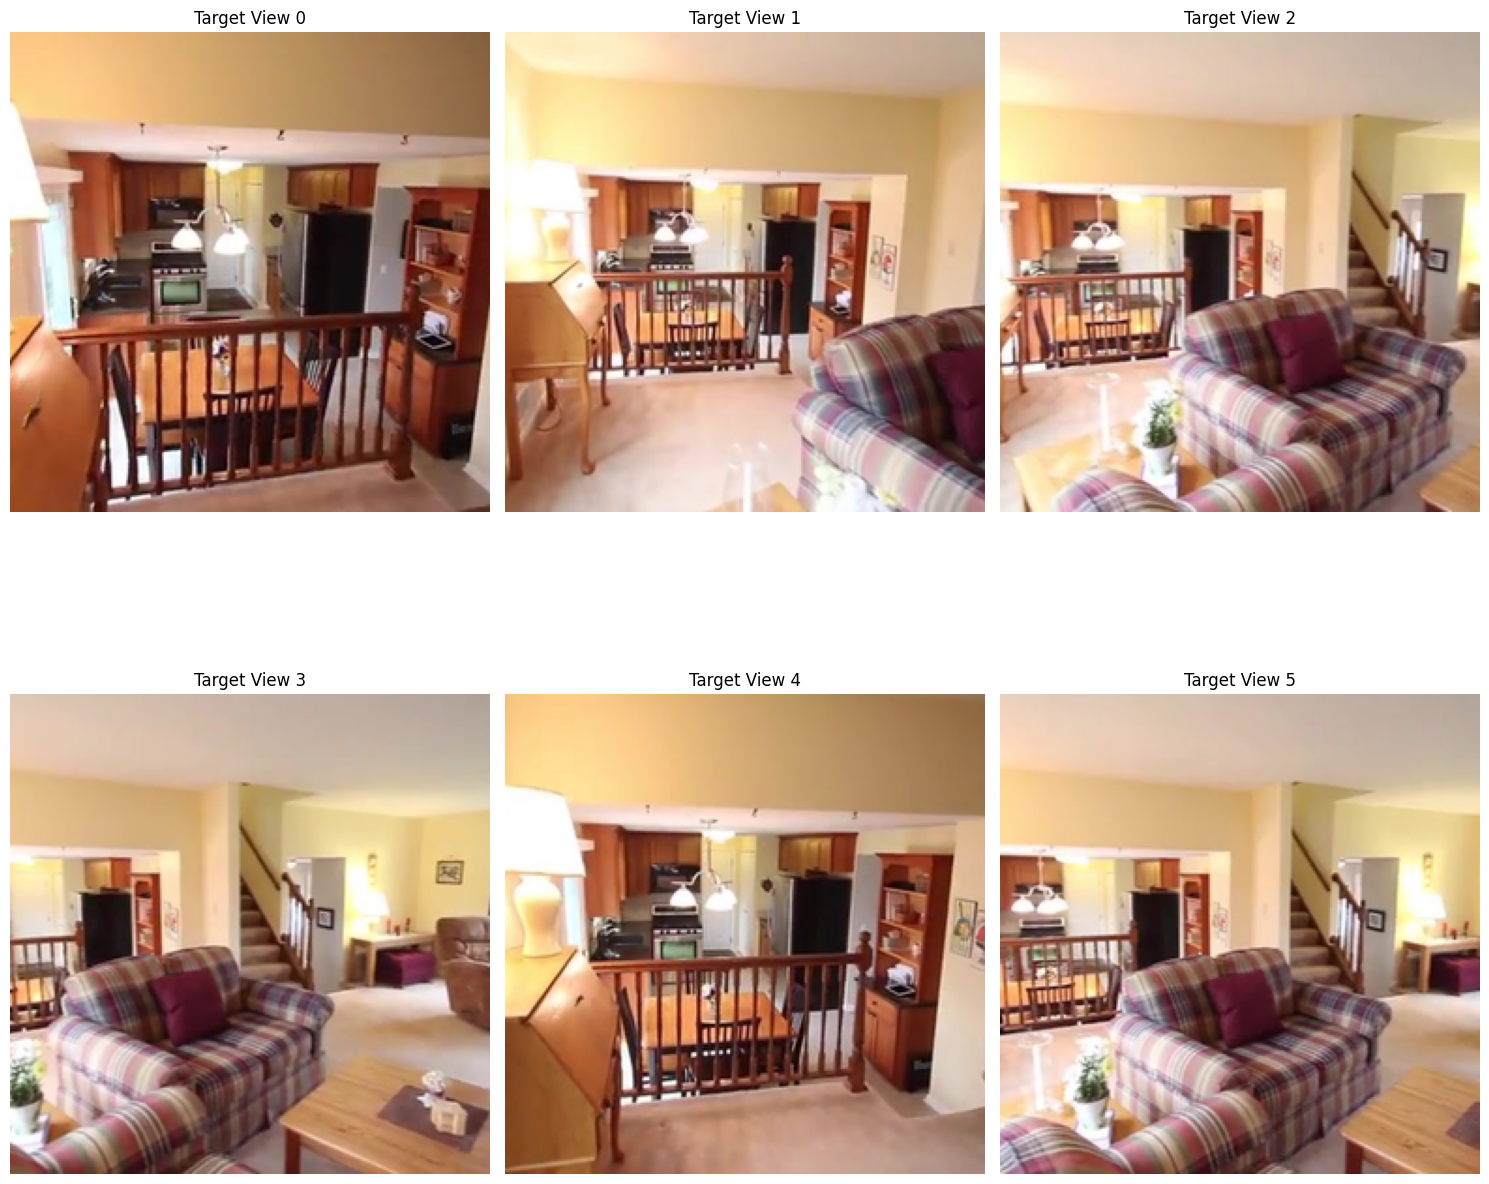


=== Target Camera Parameters ===
Target View 0:
  Translation: [-0.42746443 -0.12899143  0.7407407 ]
  Rotation (Euler XYZ, degrees): [-2.30181685 -5.97023944 -1.11963743]

Target View 1:
  Translation: [-0.07345207 -0.01185247  0.03912842]
  Rotation (Euler XYZ, degrees): [-0.30671056 -7.96348314 -1.68807372]

Target View 2:
  Translation: [ 0.14118947  0.03705396 -0.23954135]
  Rotation (Euler XYZ, degrees): [ 0.95396196 -0.84306608  0.33710871]

Target View 3:
  Translation: [ 0.23669681  0.06116434 -0.3063425 ]
  Rotation (Euler XYZ, degrees): [ 1.51755732 11.65945883  2.35614435]

Target View 4:
  Translation: [-0.35201785 -0.08575266  0.5013784 ]
  Rotation (Euler XYZ, degrees): [-1.4927652  -6.56878136 -1.20886072]

Target View 5:
  Translation: [ 0.191269    0.05153313 -0.28168637]
  Rotation (Euler XYZ, degrees): [1.27272631 5.07751699 1.2101178 ]

Camera positions along z-axis: [-0.3063425123691559, 0.7407407164573669]
Using cameras at indices [0, 1]
Starting position: [-0.4

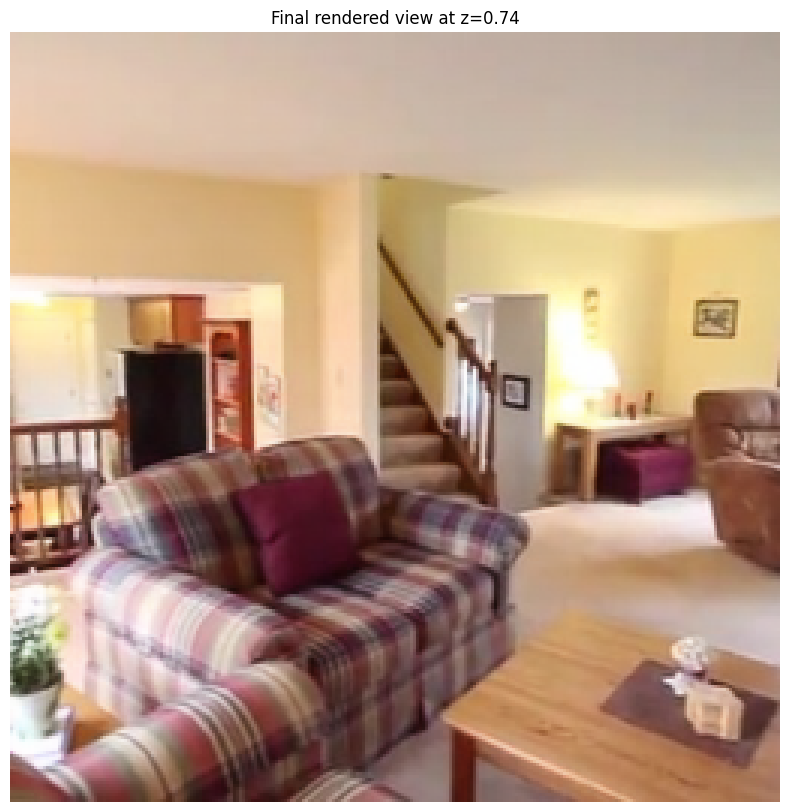

Step 2/20: Generating view at position [-0.42746443 -0.12899143  0.54074067]


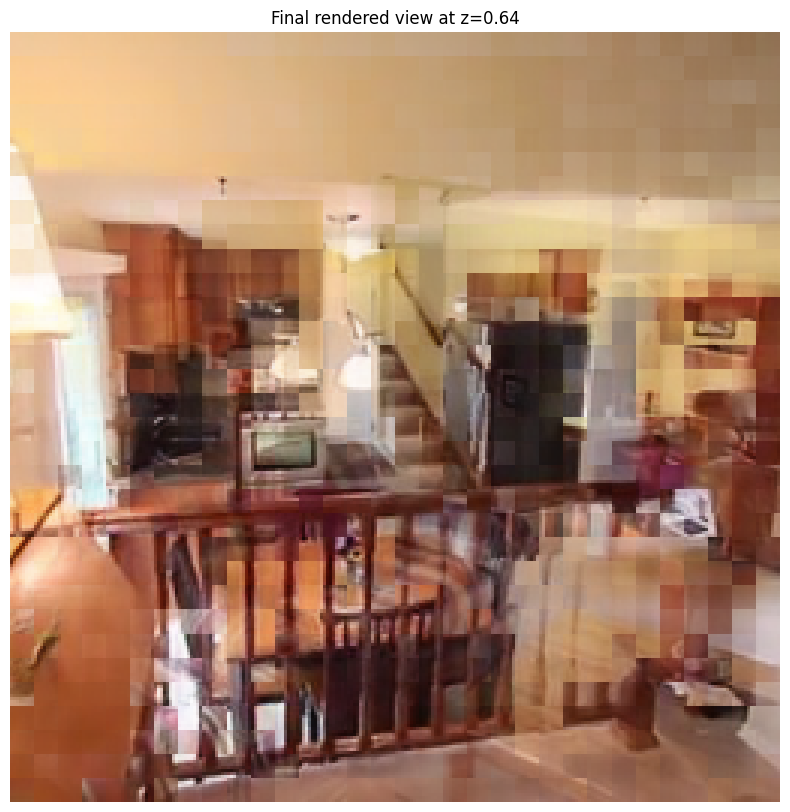

Step 3/20: Generating view at position [-0.42746443 -0.12899143  0.44074067]


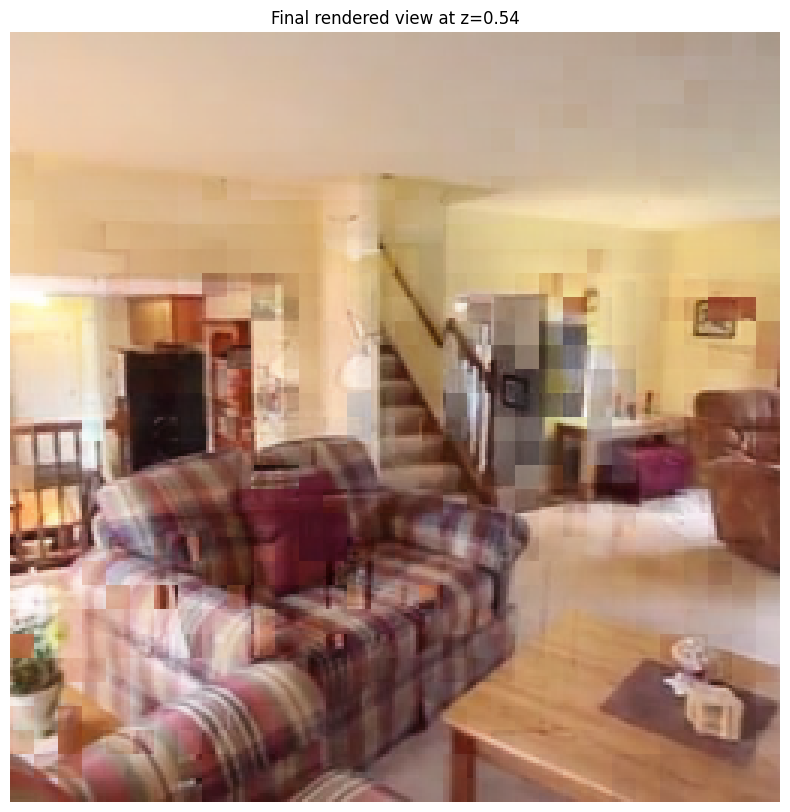

Step 4/20: Generating view at position [-0.42746443 -0.12899143  0.34074068]


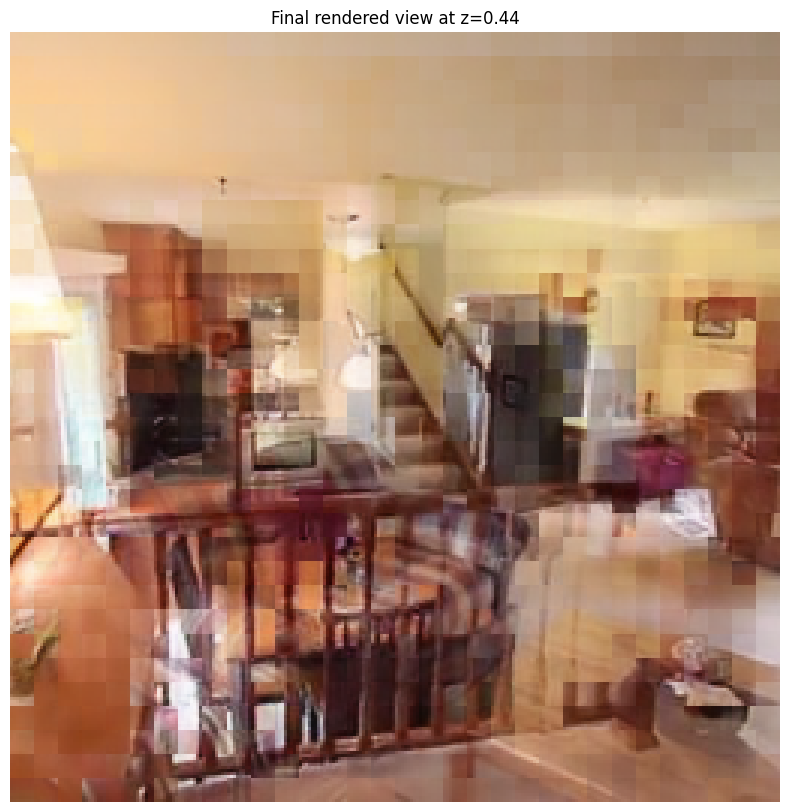

Step 5/20: Generating view at position [-0.42746443 -0.12899143  0.24074069]


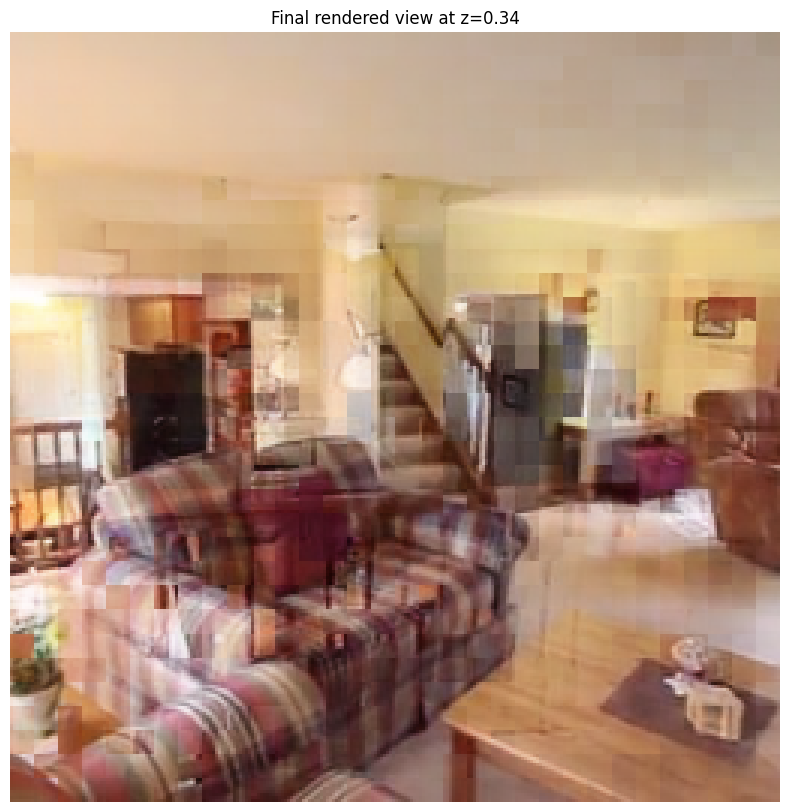

Step 6/20: Generating view at position [-0.42746443 -0.12899143  0.1407407 ]


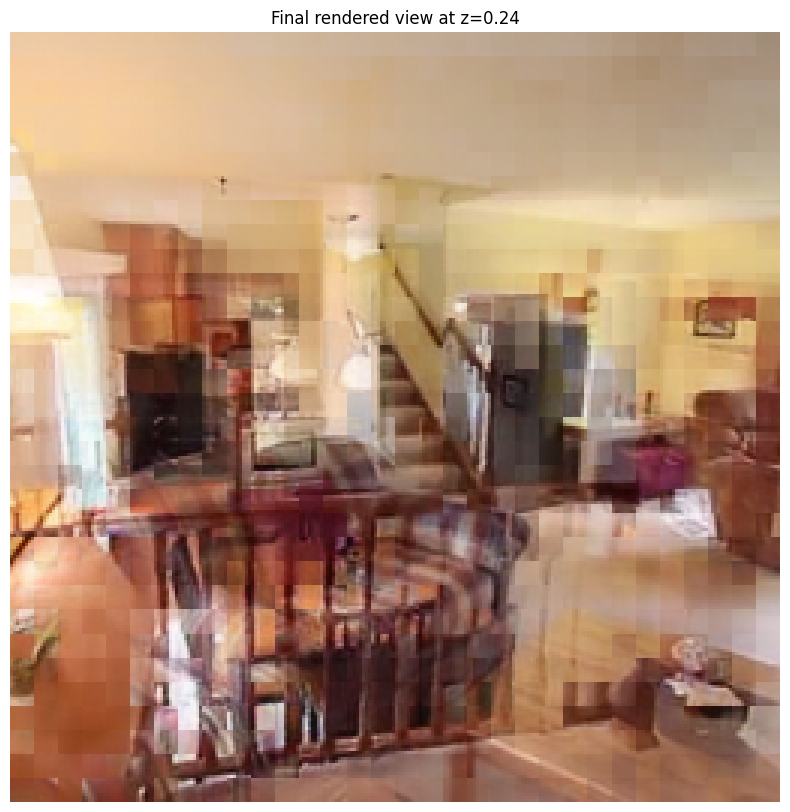

Step 7/20: Generating view at position [-0.42746443 -0.12899143  0.04074069]


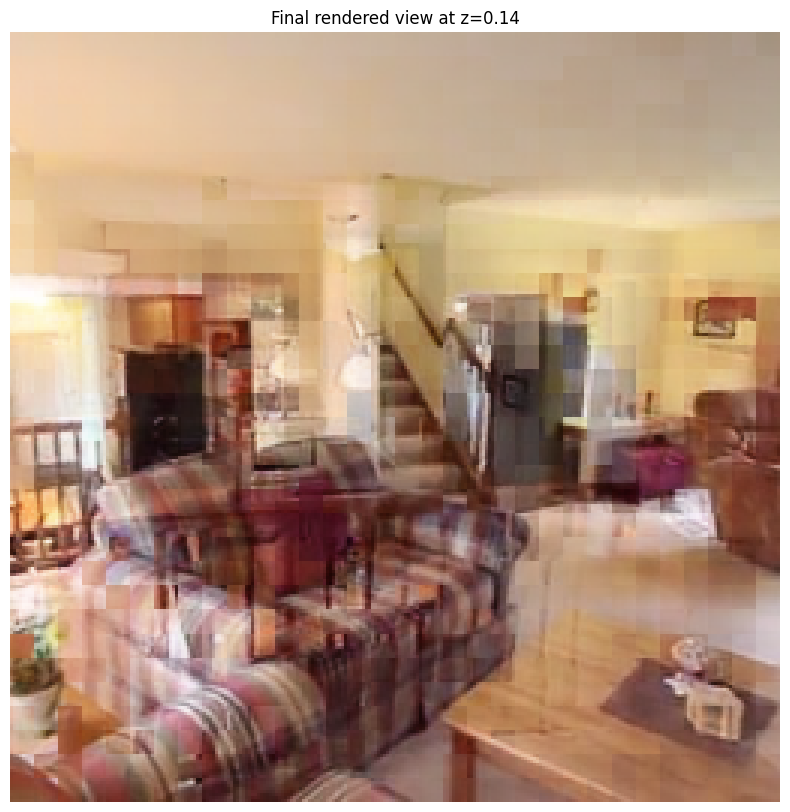

Step 8/20: Generating view at position [-0.42746443 -0.12899143 -0.05925931]


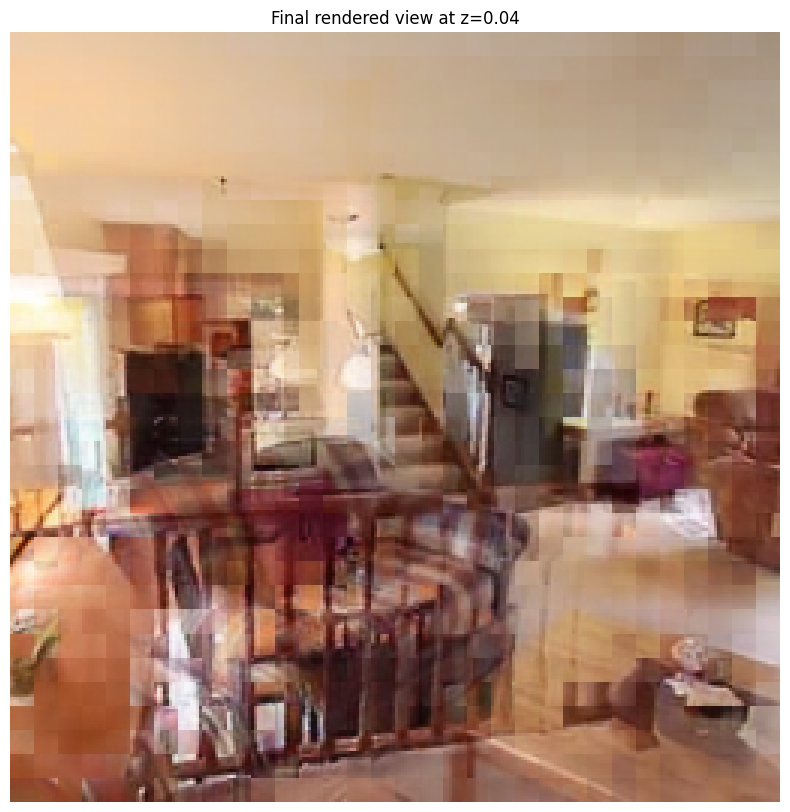

Step 9/20: Generating view at position [-0.42746443 -0.12899143 -0.15925932]


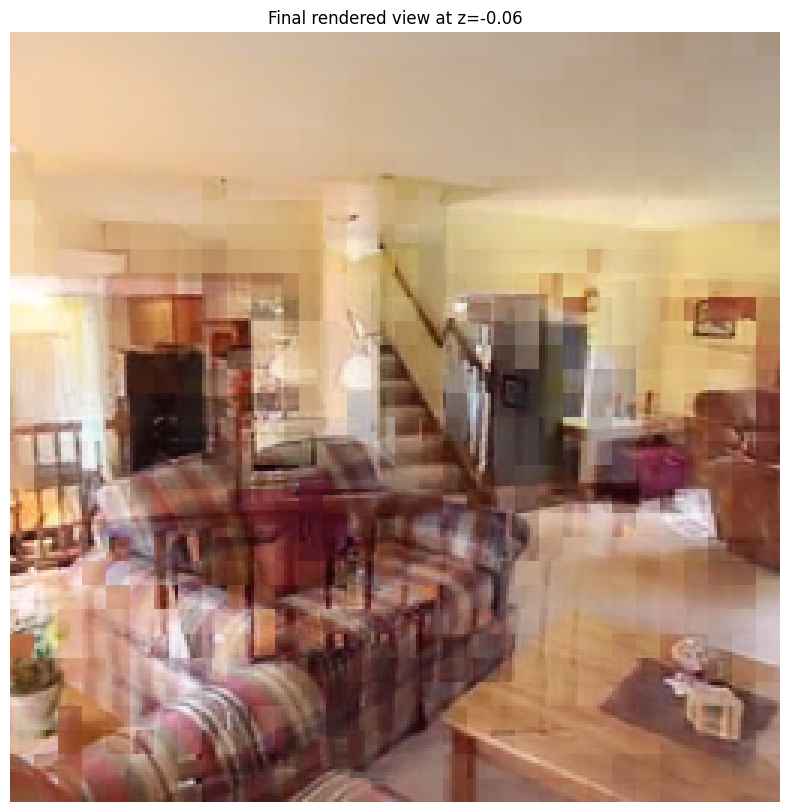

Step 10/20: Generating view at position [-0.42746443 -0.12899143 -0.2592593 ]


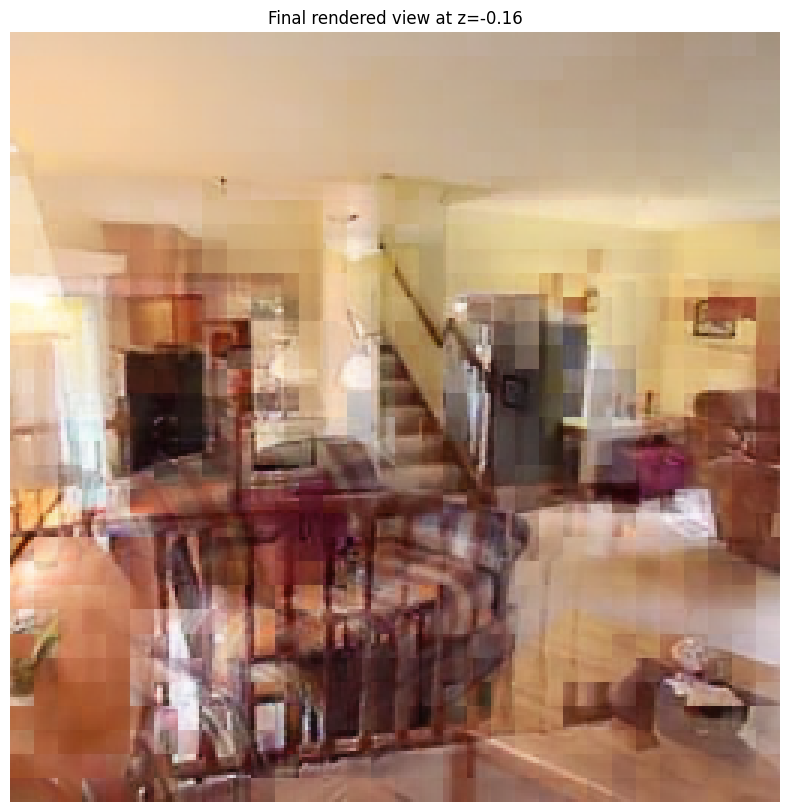

Step 11/20: Generating view at position [-0.42746443 -0.12899143 -0.3592593 ]


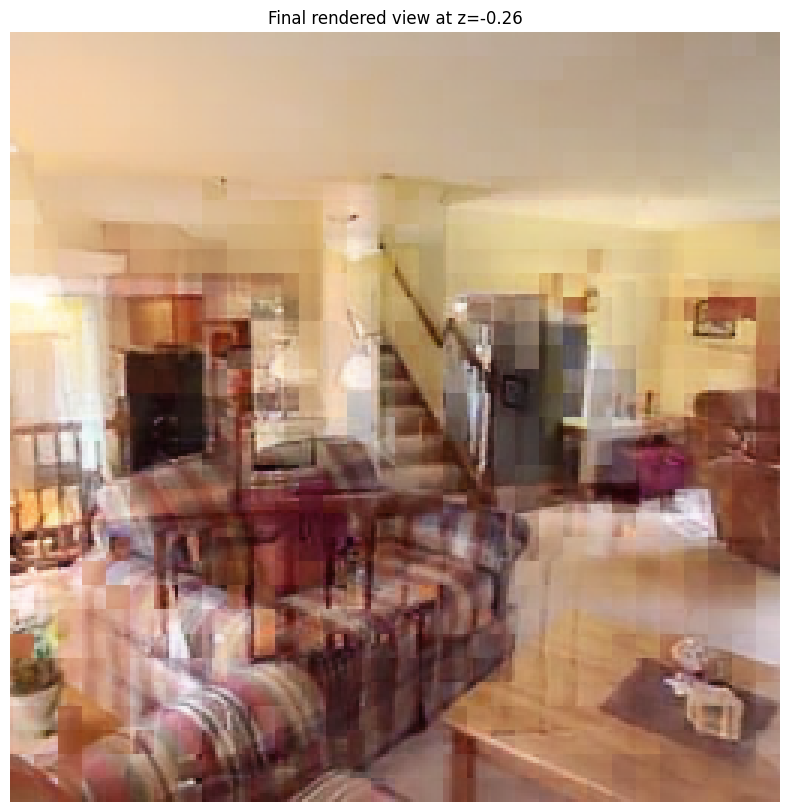

Step 12/20: Generating view at position [-0.42746443 -0.12899143 -0.4592593 ]


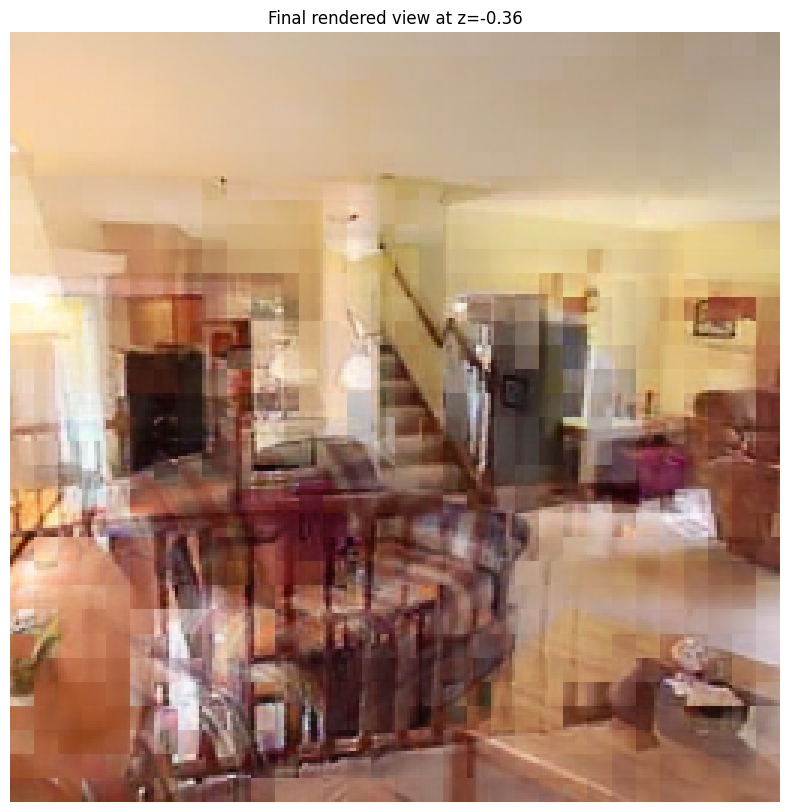

Step 13/20: Generating view at position [-0.42746443 -0.12899143 -0.5592593 ]


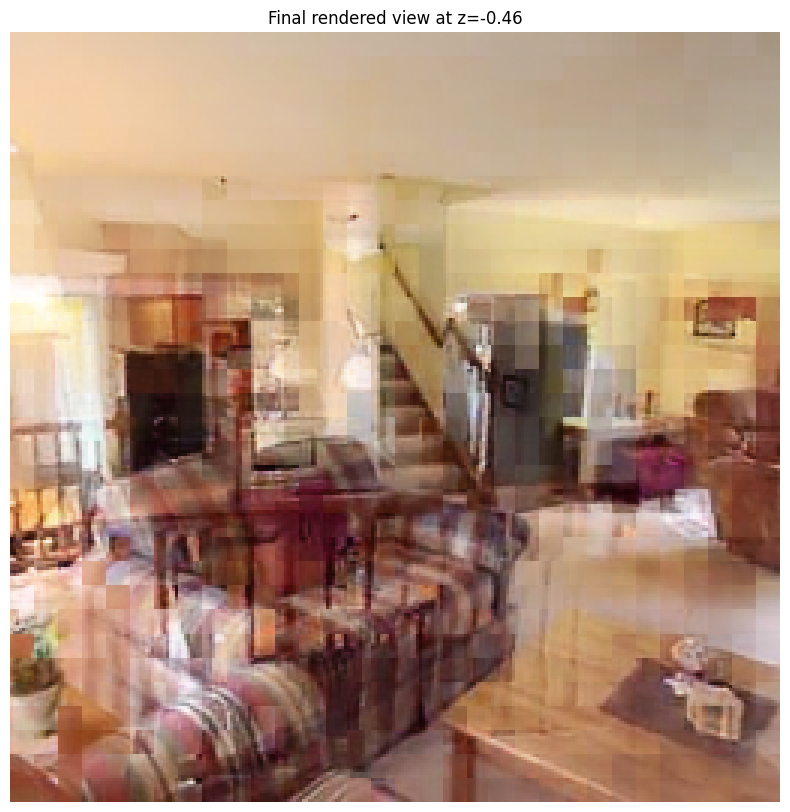

Step 14/20: Generating view at position [-0.42746443 -0.12899143 -0.6592593 ]


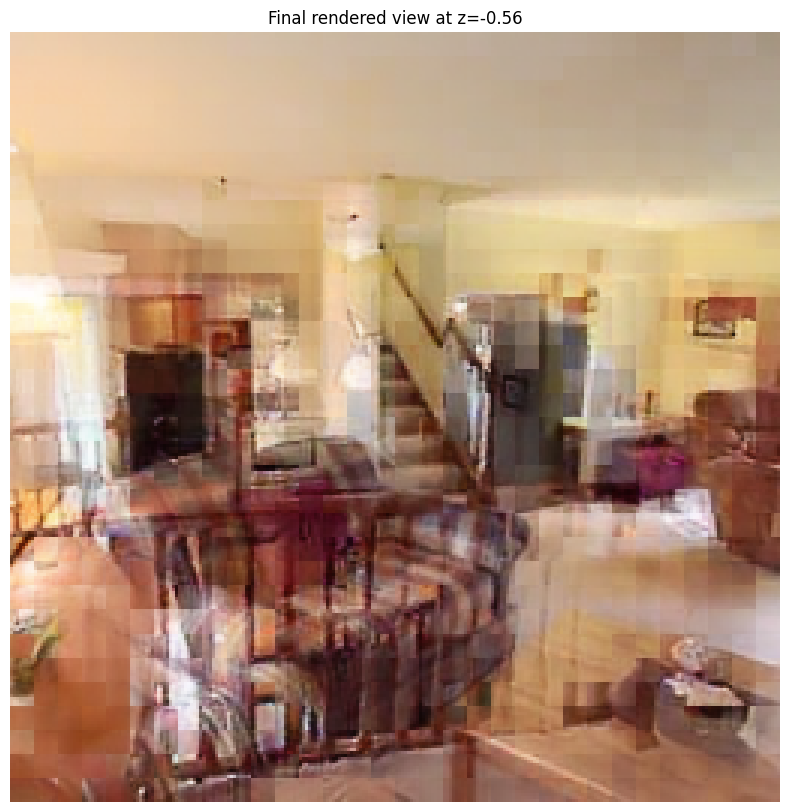

Step 15/20: Generating view at position [-0.42746443 -0.12899143 -0.75925934]


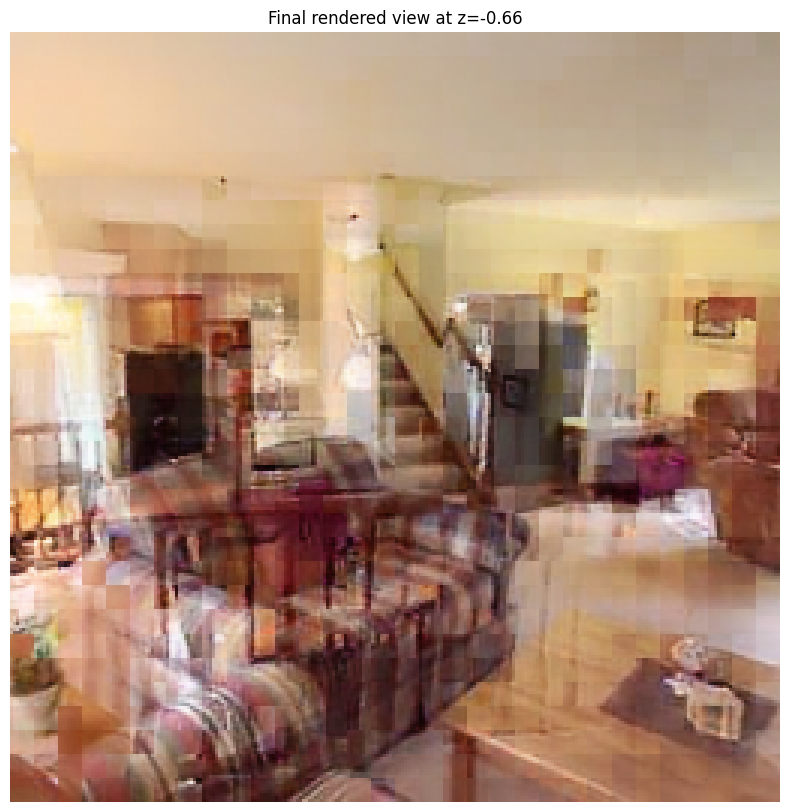

Step 16/20: Generating view at position [-0.42746443 -0.12899143 -0.85925937]


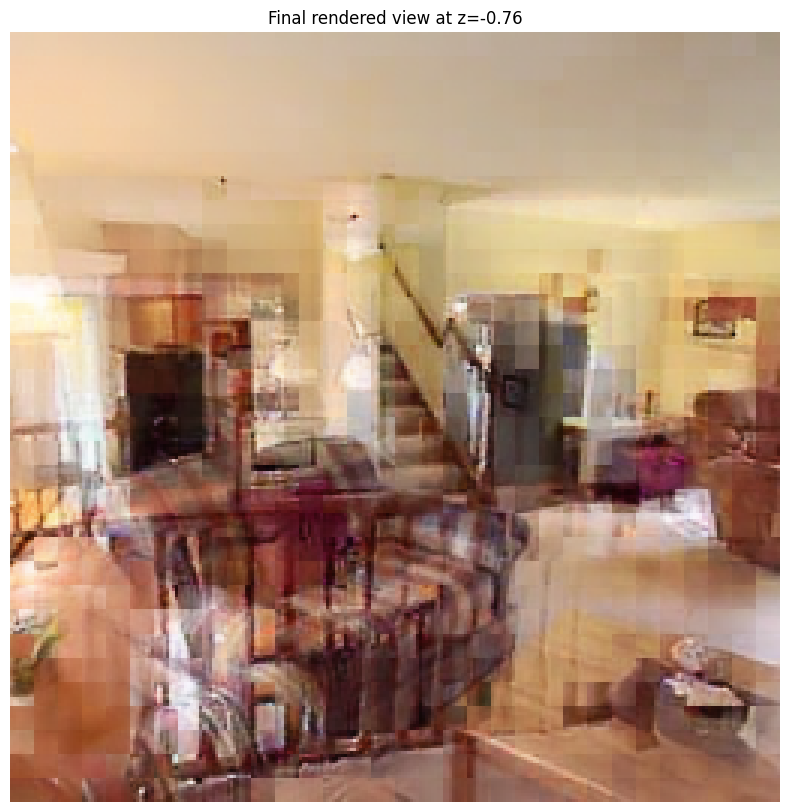

Step 17/20: Generating view at position [-0.42746443 -0.12899143 -0.9592594 ]


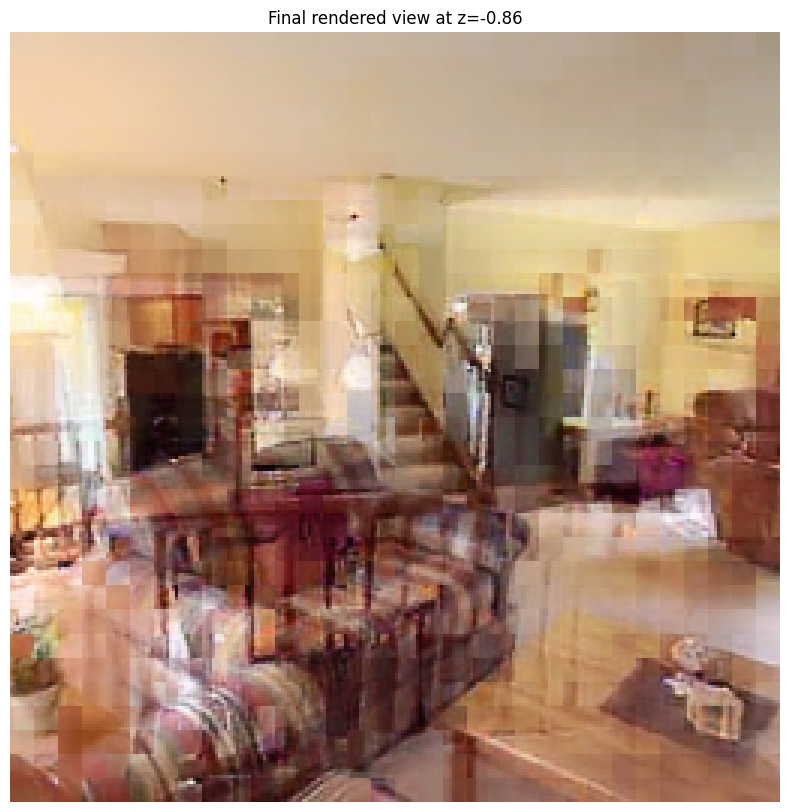

Step 18/20: Generating view at position [-0.42746443 -0.12899143 -1.0592594 ]


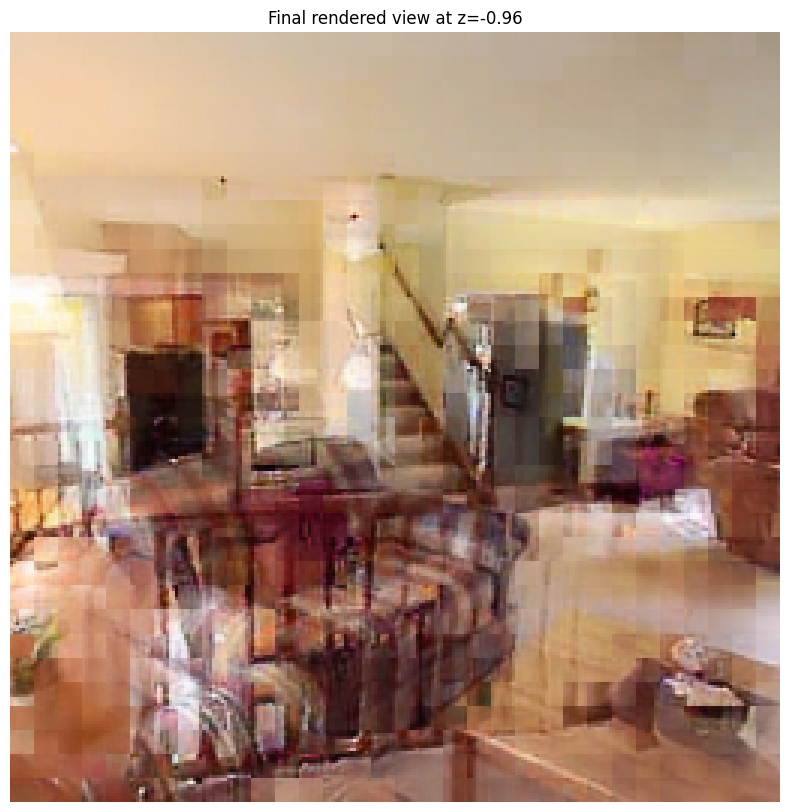

Step 19/20: Generating view at position [-0.42746443 -0.12899143 -1.1592594 ]


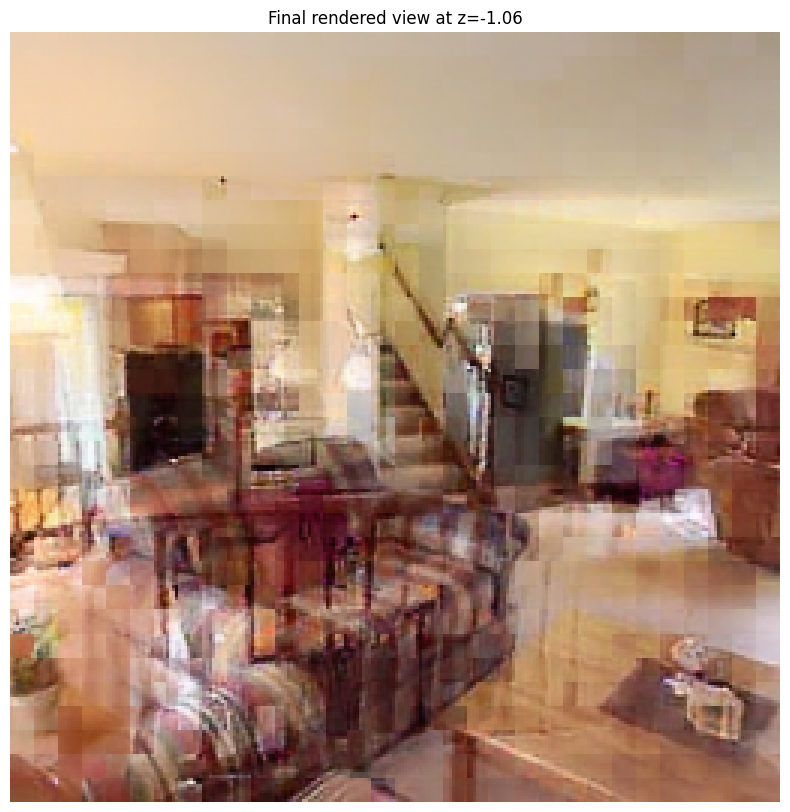

Step 20/20: Generating view at position [-0.42746443 -0.12899143 -1.2592595 ]


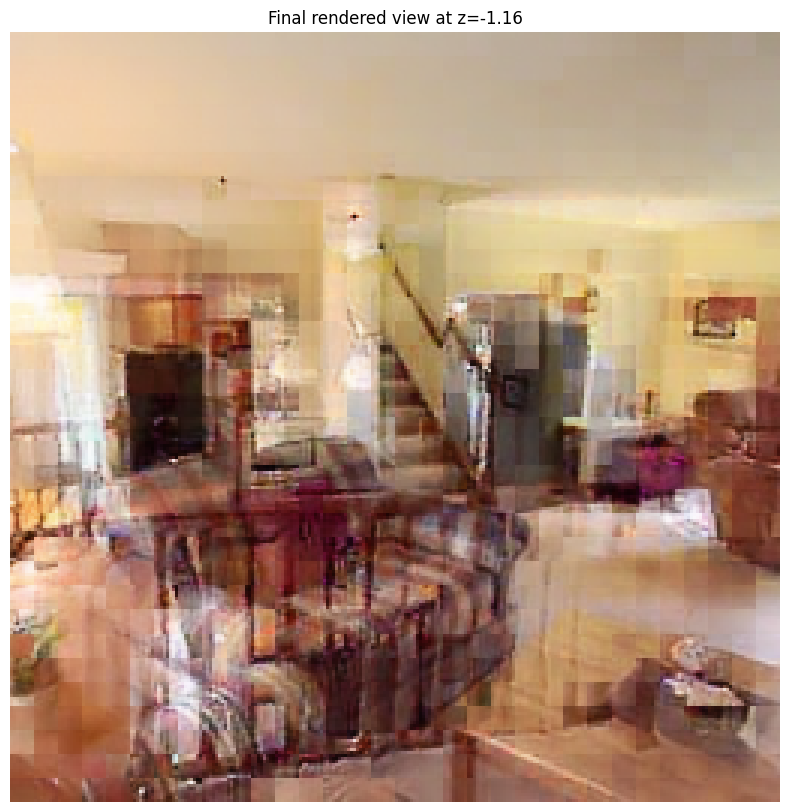

Final position reached: [-0.42746443 -0.12899143 -1.2592595 ]


(array([[[0.9140625 , 0.80859375, 0.703125  ],
         [0.9140625 , 0.80859375, 0.703125  ],
         [0.9140625 , 0.80859375, 0.703125  ],
         ...,
         [0.6484375 , 0.59765625, 0.515625  ],
         [0.65234375, 0.59765625, 0.51953125],
         [0.65625   , 0.6015625 , 0.51953125]],
 
        [[0.9140625 , 0.80078125, 0.69921875],
         [0.9140625 , 0.8046875 , 0.69921875],
         [0.9140625 , 0.80078125, 0.69921875],
         ...,
         [0.65234375, 0.60546875, 0.51953125],
         [0.65625   , 0.6015625 , 0.51953125],
         [0.65625   , 0.6015625 , 0.51953125]],
 
        [[0.91796875, 0.8046875 , 0.703125  ],
         [0.91796875, 0.8046875 , 0.69921875],
         [0.91796875, 0.8046875 , 0.69921875],
         ...,
         [0.6484375 , 0.6015625 , 0.515625  ],
         [0.65234375, 0.6015625 , 0.51953125],
         [0.65234375, 0.59765625, 0.515625  ]],
 
        ...,
 
        [[0.5546875 , 0.3125    , 0.20019531],
         [0.546875  , 0.30664062, 0.19433

In [24]:
render_incremental(scene_idx=8, step_size=0.1, num_steps=20, axis='z', positive_direction=False)